# Mean Variance Frontier with Short Sales Constraints

The code below calculates mean variances frontiers for two cases *(1)* when there are no restrictions on the portfolio weights and *(2)* when we impose the restriction that no weights can be negative.

The latter case requires a numerical minimization routine. This notebook uses the packages JuMP (for the interface) and Ipopt (for the optimization algorithm).

## Load Packages and Extra Functions

In [1]:
using Dates, LinearAlgebra, JuMP, Ipopt        

include("jlFiles/printmat.jl")

printwhere (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))       #use pyplot or gr
gr(size=(480,320))
default(fmt = :svg)

# Traditional MV Calculations 

(no constraints)

In [3]:
μ = [11.5; 9.5; 6]/100      #expected returns
Σ  = [166  34  58;          #covariance matrix
       34  64   4;
       58   4 100]/100^2                  
Rf = 0.03

printblue("μ:")
printmat(μ)
printblue("Σ:")
printmat(Σ)
printblue("Rf:")
printlnPs(Rf)

μ:
     0.115
     0.095
     0.060

Σ:
     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010

Rf:
     0.030


## From Chapter on MV Analysis

The file included below contains the functions `MVCalc()`, `MVCalcRf()` and `MVTangencyP()` from the chapter on MV analysis.

In [4]:
include("jlFiles/MvCalculations.jl")

MVTangencyP

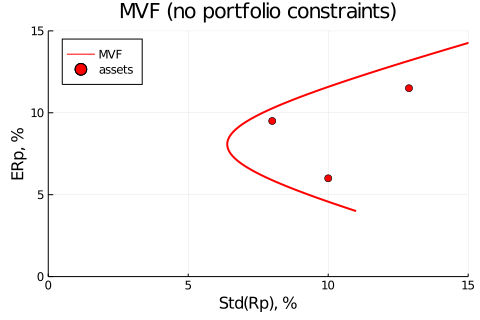

In [5]:
μstar  = range(0.04,stop=0.15,length=201)      
L      = length(μstar)
StdRp  = fill(NaN,L)
for i = 1:L
    StdRp[i] = MVCalc(μstar[i],μ,Σ)[1]
end    

p1 = plot( StdRp*100,μstar*100,
           linecolor = :red,
           linewidth = 2,
           label = "MVF",
           legend = :topleft,
           xlim = (0,15),
           ylim = (0,15),
           title = "MVF (no portfolio constraints)",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)

# MV Frontier when Short Sales are Not Allowed

The code below solves (numerically) the following minimization problem 

$\min \text{Var}(R_p) \: \text{ s.t. } \: \text{E}R_p = \mu^*$,
 
and where we also require $w_i\ge 0$ and $\sum_{i=1}^{n}w_{i}=1$.

In [6]:
function MeanVarNoSSPs(μ,Σ,μstar)   #MV with no short-sales, numerical minimization
    n = length(μ)
    if minimum(μ) <= μstar <= maximum(μ)      #try only if feasible
        model = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level" => 1))
        @variable(model,w[i=1:n] >= 0.0)       #no short sales
        @objective(model,Min,w'*Σ*w)           #minimize portfolio variance 
        @constraint(model,sum(w) == 1.0)       #w sums to 1
        @constraint(model,w'*μ == μstar)       #mean equals μstar
        optimize!(model)
        if has_values(model)
            w_p = value.(w)
            StdRp = sqrt(w_p'Σ*w_p)
        end
    else    
        (w_p,StdRp) = (NaN,NaN)                
    end    
    return StdRp,w_p
end

MeanVarNoSSPs (generic function with 1 method)

In [7]:
Std_no_ss = fill(NaN,length(μstar))
for i = 1:length(μstar)
    Std_no_ss[i] = MeanVarNoSSPs(μ,Σ,μstar[i])[1]     #[1] to get first output
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



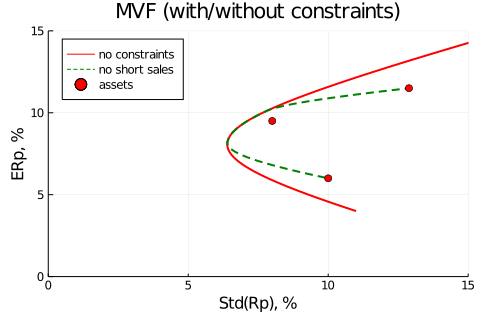

In [8]:
p1 = plot( [StdRp Std_no_ss]*100,μstar*100,
           linecolor = [:red :green],
           linestyle = [:solid :dash],
           linewidth = 2,
           label = ["no constraints" "no short sales"],
           xlim = (0,15),
           ylim = (0,15),
           legend = :topleft,
           title = "MVF (with/without constraints)",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)